# EMET2007 Week 11
    
We are continuing our analysis of the Australian CPI and inflation time series.  The data are the same as last week. Recall that the csv-file contains one single time series of the Australian Consumer Price Index (quarterly) starting in 1922:Q2 and running until 2025:Q1.  

We train our focus today on the trending behaviour of CPI and inflation. Are there any deterministic trends? Are there any stochastic trends? We conduct unit root tests and discover the problems created by trend behaviour.

## Imports and loading data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import numpy as np

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv('drive/MyDrive/EMET2008/datasets/cpi_aus_2025.csv')

In [2]:
df = pd.read_csv('../datasets/cpi_aus_2025.csv')

Run this cell once you've loaded the data:

In [3]:
df['date'] = pd.to_datetime(df['time'], format='%b-%Y')
df.index = pd.DatetimeIndex(df.date, name='quarter').to_period('Q')

## Exercise 1

Re-create the time series variables from Exercise 1 of last week's computer lab: ``cpi`` and ``infl``. The ``infl`` time series is created as annualized log-differences. 


In [4]:
df['logcpi'] = np.log(df.cpi)
df['infl'] = 400 * df.logcpi.diff()

## Exercise 2

To build a decent forecast-model, a crash course on the history of monetary policy in Australia is helpful: 

* fixed exchange rate until early 1970s
* floating of Australian Dollar late 1983
* inflation targeting since early 1990s

In light of this summary, look again at the time series plot of ``infl``. It would seem reasonable to limit our data set to the years 1984 and beyond. This gives us a sufficient number of observations to estimate simple AR models, while also minimizing the effect of non-random policy changes.

**For the rest of this computer lab, restrict your** ``cpi`` **time series to observations ranging from 1984:Q1 all the way to 2025:Q1.**


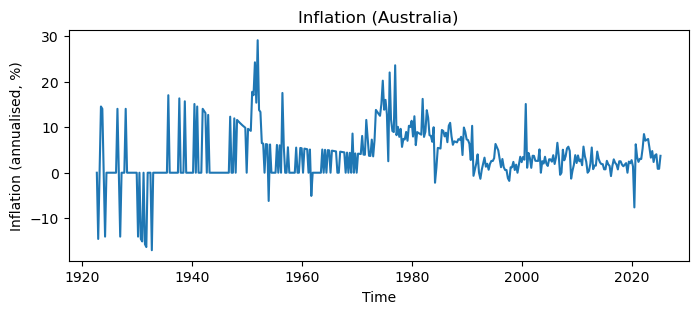

In [5]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(df.date, df.infl)
ax.set_xlabel('Time')
ax.set_ylabel('Inflation (annualised, %)')
ax.set_title('Inflation (Australia)')
plt.show()

In [6]:
# Need to reload the data to make a proper subset as though it really
# did start in 1984; if we just take a subset of the df series it leads
# to inconsistent results depending on which variable we are analysing

df_1984 = pd.read_csv('../datasets/cpi_aus_2025.csv')
df_1984['date'] = pd.to_datetime(df_1984['time'], format='%b-%Y')
df_1984.index = pd.DatetimeIndex(df_1984.date, name='quarter').to_period('Q')
df_1984 = df_1984['1984Q1' <= df_1984.index].copy()
#df_1984['cpi'] = df_1984.GCPIAG
df_1984['logcpi'] = np.log(df_1984.cpi)
df_1984['infl'] = 400 * df_1984.logcpi.diff()
df_1984.head()

time   cpi       date    logcpi      infl
quarter                                               
1984Q1   Mar-1984  36.3 1984-03-01  3.591818       NaN
1984Q2   Jun-1984  36.4 1984-06-01  3.594569  1.100413
1984Q3   Sep-1984  36.9 1984-09-01  3.608212  5.457111
1984Q4   Dec-1984  37.4 1984-12-01  3.621671  5.383661
1985Q1   Mar-1985  37.9 1985-03-01  3.634951  5.312163

## Exercise 3

Test if ``cpi`` contains a unit root. Do this in two ways: manually by running the underlying autoregression, and automatically by using the ``adfuller`` convenience function we imported at the start.  

Does ``cpi`` contain a unit root?  What are the ramifications of your findings? Be careful with your interpretation of the test results.

Use a simple AR(1) specification as the underlying autoregressive model. While it may be desirable to explore richer specifications (which allow for higher lag orders) the time series may be too short (that is, not contain enough observations) to reliably estimate higher order autoregressive models.

Recall from the lecture: If you want to test a time series $ Y_t $ for a unit root using an AR(1) specification, you are considering the AR(1) model (including a deterministic trend)

$$ Y_t = \beta_0 + \alpha \cdot t + \beta_1 Y_{t-1} + u_t $$

But instead of testing whether $ \beta_1 = 0 $ you rewrite the model equivalently as

$$ \Delta Y_t = \beta_0 + \alpha \cdot t +  \delta Y_{t-1} + u_t $$

and test the null $ \texttt{H}_0: \delta = 0 $ against the alternative  $\texttt{H}_1: \delta < 0 $. 

In [7]:
df_1984['diff_cpi'] = df_1984.cpi.diff()
df_1984['trend'] = range(1, len(df_1984.cpi) + 1)
df_1984['l1cpi'] = df_1984.cpi.shift(1)
df_1984.head()

time   cpi       date    logcpi      infl  diff_cpi  trend  l1cpi
quarter                                                                       
1984Q1   Mar-1984  36.3 1984-03-01  3.591818       NaN       NaN      1    NaN
1984Q2   Jun-1984  36.4 1984-06-01  3.594569  1.100413       0.1      2   36.3
1984Q3   Sep-1984  36.9 1984-09-01  3.608212  5.457111       0.5      3   36.4
1984Q4   Dec-1984  37.4 1984-12-01  3.621671  5.383661       0.5      4   36.9
1985Q1   Mar-1985  37.9 1985-03-01  3.634951  5.312163       0.5      5   37.4

In [8]:
df_1984.tail()

time    cpi       date    logcpi      infl  diff_cpi  trend  \
quarter                                                                    
2024Q1   Mar-2024  137.4 2024-03-01  4.922896  3.802588       1.3    161   
2024Q2   Jun-2024  138.8 2024-06-01  4.933034  4.055067       1.4    162   
2024Q3   Sep-2024  139.1 2024-09-01  4.935193  0.863620       0.3    163   
2024Q4   Dec-2024  139.4 2024-12-01  4.937347  0.861760       0.3    164   
2025Q1   Mar-2025  140.7 2025-03-01  4.946630  3.712986       1.3    165   

         l1cpi  
quarter         
2024Q1   136.1  
2024Q2   137.4  
2024Q3   138.8  
2024Q4   139.1  
2025Q1   139.4

In [9]:
unit_root_ar1 = smf.ols('diff_cpi ~ trend + l1cpi', data=df_1984, 
                        missing='drop').fit(use_t=False)
unit_root_ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               diff_cpi   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     3.486
Date:                Mon, 05 May 2025   Prob (F-statistic):             0.0330
Time:                        11:55:54   Log-Likelihood:                -135.83
No. Observations:                 164   AIC:                             277.7
Df Residuals:                     161   BIC:                             287.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2524      0.522     -0.484      0.628      -1.275       0.770
trend         -0.0089      0.008     -1.123      0.262      -0.024       0.007
l1cpi          0.0195      0.014      1.393      0.164      -0.008       0.047
==============================================================================
Omnibus:                       28.433   Durbin-Watson:                   1.333
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.961
Skew:                           0.018   Prob(JB):                     1.72e-48
Kurtosis:                       8.673   Cond. No.                     1.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
adfuller(df_1984.cpi, maxlag = 0, regression='ct')
# maxlag = 0: k = 0
# regression = 'ct': constant + time trend (default is 'c', 
# constant only)

(1.3932894319320968,
 1.0,
 0,
 164,
 {'1%': -4.01505920353557,
  '5%': -3.4376069791319046,
  '10%': -3.1429668598830545},
 277.6566200886984)

**Interpretation:** t-stat is the same as the one returned above; p-value = 1.0 > 0.05 and we do not reject the null hypothesis of a unit root.

This means that we cannot treat the CPI time series as nonstationary.

## Exercise 4 

Redo the previous part, this time testing ``infl`` for a unit root.



In [11]:
df_1984['diff_infl'] = df_1984.infl.diff()
df_1984['l1infl'] = df_1984.infl.shift(1)
df_1984.trend = df_1984.trend.shift(1)
df_1984.head()

time   cpi       date    logcpi      infl  diff_cpi  trend  \
quarter                                                                   
1984Q1   Mar-1984  36.3 1984-03-01  3.591818       NaN       NaN    NaN   
1984Q2   Jun-1984  36.4 1984-06-01  3.594569  1.100413       0.1    1.0   
1984Q3   Sep-1984  36.9 1984-09-01  3.608212  5.457111       0.5    2.0   
1984Q4   Dec-1984  37.4 1984-12-01  3.621671  5.383661       0.5    3.0   
1985Q1   Mar-1985  37.9 1985-03-01  3.634951  5.312163       0.5    4.0   

         l1cpi  diff_infl    l1infl  
quarter                              
1984Q1     NaN        NaN       NaN  
1984Q2    36.3        NaN       NaN  
1984Q3    36.4   4.356697  1.100413  
1984Q4    36.9  -0.073449  5.457111  
1985Q1    37.4  -0.071498  5.383661

In [12]:
unit_root_ar1_infl = smf.ols('diff_infl ~ trend + l1infl', data=df_1984, missing='drop').fit(use_t=False)
unit_root_ar1_infl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              diff_infl   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     32.81
Date:                Mon, 05 May 2025   Prob (F-statistic):           1.14e-12
Time:                        11:56:30   Log-Likelihood:                -379.58
No. Observations:                 163   AIC:                             765.2
Df Residuals:                     160   BIC:                             774.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8760      0.529      5.433      0.000       1.838       3.914
trend         -0.0115      0.004     -2.616      0.009      -0.020      -0.003
l1infl        -0.5774      0.071     -8.100      0.000      -0.717      -0.438
==============================================================================
Omnibus:                       28.222   Durbin-Watson:                   2.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.223
Skew:                           0.406   Prob(JB):                     1.31e-31
Kurtosis:                       7.504   Cond. No.                         258.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
adfuller(df_1984.infl.dropna(), maxlag = 0, regression='ct')

(-8.100266992144075,
 4.190029386986492e-11,
 0,
 163,
 {'1%': -4.015411436892989,
  '5%': -3.437775542101628,
  '10%': -3.143065472942659},
 765.1583154201815)

**Interpretation:** t-stat is the same as the one returned above; p-value < 0.05 and we reject the null hypothesis of a unit root in favour of the alternative hypothesis of stationarity.

## Exercise 5 

The ``cpi`` time series runs from 1984:Q1 to 2025:Q1.

To measure forecast performance, we could follow this little algorithm:

### Algorithm for Pseudo Out-of-Sample Forecasts

1) pretend like your data already ends in $ s $ =2004:Q4 (although it actually ends in 2025:Q1)

2) estimate an AR(1) model for $\texttt{infl}_t$ for the time frame 1984:Q1 to $s$

3) calculate a `pseudo` forecast $\widehat{\texttt{infl}}_{s+1|s}$ for period $s+1$ 

4) compare the pseudo forecast to the actual realization $\texttt{infl}_{s+1}$; the difference is the pseudo forecast error: $\texttt{infl}_{s+1} - \widehat{\texttt{infl}}_{s+1|s}$

5) shift $s$ up by one period and jump back to step 2 

Repeat until you reach the end of your data set. You end up with 17 years' worth of pseudo forecasts and the associated pseudo forecast
        errors.

<hr>

Alex has written a reasonably robust little ``Python`` function that creates these pseudo forecasts and their errors:

<hr>


In [14]:
def ar1_pseudo(input_df, y, startdate):
    """
    Pseudo out-of-sample forecasts and errors based on AR(1) model

    Returns: 
    forecasts: time series of pseudo out-of-sample forecasts
    forecast_errors: time series of pseudo out-of-sample forecast errors

    Arguments:
    input_df: a pandas DataFrame containing:
            the variable of interest, y
            an index with frequency 'Q' like we created at the start
    y: a string of the name of the variable of interest
    startdate: a string of the first quarter we want to
                produce a forecast for (e.g. '2005Q1')
    """
    
    # Create the variables we need
    df = pd.DataFrame()  # empty pandas df
    df['y'] = input_df[y]  # get dependent variable
    df['lag_y'] = df.y.shift(1)  # create its first lag
    df['trend'] = range(len(input_df[y]))  # create trend variable
    # create empty column for each (s + 1) forecast to go in
    df['next_forecast'] = pd.Series(dtype='float64')
    
    # Get starting quarter
    start_period = pd.Period(startdate, freq='Q')
    
    # Iterate over df rows
    for i, row in df.iterrows():
        # Ignore all rows that are before period s
        if row.name < start_period - 1:
                continue

        # Otherwise:
        # create subsample containing all rows in periods
        # up to and including s
        df_sub = df[df.index <= row.name]  
        
        # fit AR1 model using that subsample
        ar_tmp = smf.ols(f'y ~ lag_y + trend', 
                            data = df_sub,
                            missing='drop').fit()
        
        # specify the values we need to feed to the model for our
        # forecast
        df_aux = {'lag_y' : row.y,
                  'trend' : row.trend,
                 }
        prediction = ar_tmp.predict(df_aux)  # create the forecast
        df.at[i, 'next_forecast'] = prediction[0]  # modify the df
      
    # Add another row to the df to accommodate the final forecast
    df.loc[df.iloc[-1].name + 1,:] = np.nan
    # Shift the 'next_forecast' variable so we get a value for
    # 'forecast' in the appropriate period
    df['forecast'] = df.next_forecast.shift(1)
    # Calculate each forecast error
    df['forecast_error'] = df.y - df.forecast
    
    # Only keep the relevant columns and return the df
    results_df = df[['forecast', 'forecast_error']].copy()
    results_df['date'] = results_df.index.to_timestamp()  
    # for less typing when plotting
    return results_df

Now, to generate rolling pseudo out-of-sample forecasts for inflation starting in 2005:Q1, you can call this function like so:

```
# example of a function call:
my_results = ar1_pseudo(df_1984, 'cpi', '2005Q1')

# example of plotting:
results2 = ar1_pseudo(df_1984, 'infl', '2005Q1')
fig, ax = plt.subplots()
ax.plot(results2.date, results2.forecast)
plt.show()
```

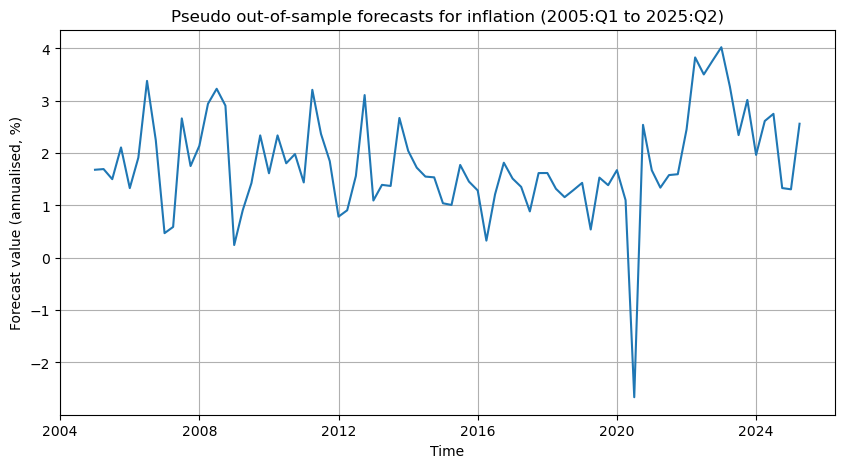

In [15]:
my_results = ar1_pseudo(df_1984, 'infl', '2005Q1')
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(my_results.date, my_results.forecast)  # or:
# ax.plot(my_results.index.start_time, my_results.forecast)
ax.set_xlabel('Time')
ax.set_ylabel('Forecast value (annualised, %)')
ax.set_title('Pseudo out-of-sample forecasts for inflation (2005:Q1 to 2025:Q2)')
ax.grid()
plt.show()

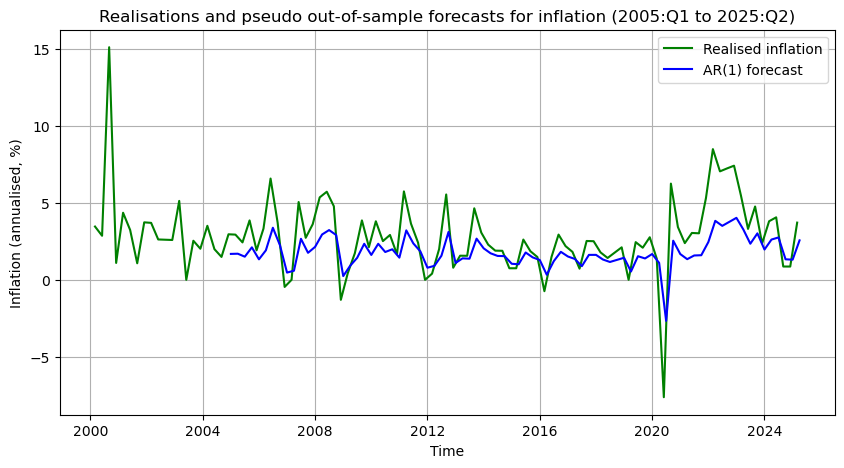

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

df_2000 = df_1984[df_1984.index >= '2000Q1']
ax.plot(df_2000.date, df_2000.infl, 
        color='green', label='Realised inflation')
ax.plot(my_results.date, my_results.forecast, 
        color='blue', label='AR(1) forecast')
ax.set_xlabel('Time')
ax.set_ylabel('Inflation (annualised, %)')
ax.set_title('Realisations and pseudo out-of-sample forecasts for inflation (2005:Q1 to 2025:Q2)')
ax.legend()
ax.grid()
plt.show()

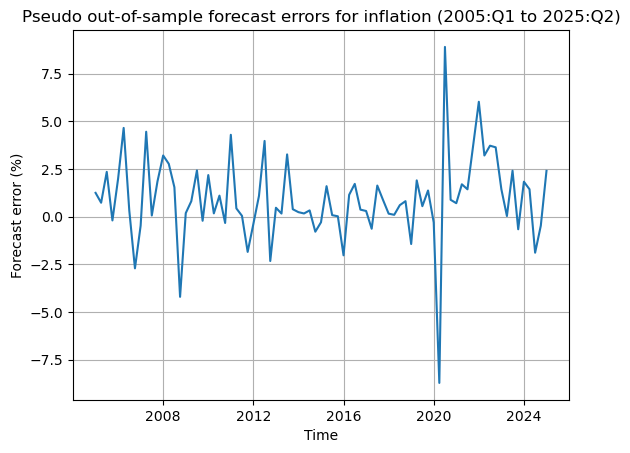

In [17]:
fig, ax = plt.subplots()

ax.plot(my_results.date, my_results.forecast_error)
ax.set_xlabel('Time')
ax.set_ylabel('Forecast error (%)')
ax.set_title('Pseudo out-of-sample forecast errors for inflation (2005:Q1 to 2025:Q2)')
ax.grid()
plt.show()

In [18]:
my_results.forecast_error.mean()

0.9136404347378116

In [19]:
my_results.forecast_error.var()

5.012763799484647